*   Nama : Gina Cahya Utami
*   Username : Gina Cahya
*   Email : ginacu.gc@gmail.com
*   Dataset : https://www.kaggle.com/septa97/100k-courseras-course-reviews-dataset?select=reviews.csv


In [2]:
import pandas as pd
df = pd.read_csv('reviews.csv')
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


**Hapus kolom yang tidak diperlukan**

In [3]:
data = df.drop(columns=['Id'])
data

,Review,Label
0,good and interesting,5
1,"This class is very helpful to me. Currently, I...",5
2,like!Prof and TAs are helpful and the discussi...,5
3,Easy to follow and includes a lot basic and im...,5
4,Really nice teacher!I could got the point eazl...,4
...,...,...
107013,Trendy topic with talks from expertises in the...,4
107014,"Wonderful! Simple and clear language, good ins...",5
107015,an interesting and fun course. thanks. dr quincy,5
107016,"very broad perspective, up to date information...",4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  107018 non-null  object
 1   Label   107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


**Data** **Cleaning**

In [5]:
data.isna().sum()

Review    0
Label     0
dtype: int64

In [6]:
print(data.duplicated().sum())

6546


In [7]:
data_baru = data.copy(deep=True)
data_baru.drop_duplicates(inplace=True)

In [8]:
print(data_baru.duplicated().sum())

0


In [9]:
data_baru.shape

(100472, 2)

**Proses** **One-Hot-Encoding**

In [10]:
category = pd.get_dummies(data_baru['Label'])
data_baru = pd.concat([data_baru, category], axis=1)
dataset = data_baru.drop(columns='Label')
dataset

,Review,1,2,3,4,5
0,good and interesting,0,0,0,0,1
1,"This class is very helpful to me. Currently, I...",0,0,0,0,1
2,like!Prof and TAs are helpful and the discussi...,0,0,0,0,1
3,Easy to follow and includes a lot basic and im...,0,0,0,0,1
4,Really nice teacher!I could got the point eazl...,0,0,0,1,0
...,...,...,...,...,...,...
107013,Trendy topic with talks from expertises in the...,0,0,0,1,0
107014,"Wonderful! Simple and clear language, good ins...",0,0,0,0,1
107015,an interesting and fun course. thanks. dr quincy,0,0,0,0,1
107016,"very broad perspective, up to date information...",0,0,0,1,0


**Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array**

In [11]:
x = dataset['Review'].values
y = dataset[[1, 2, 3, 4, 5]].values

**Membagi data untuk training dan data untuk testing**

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(x_test)

20095

**Tokenization**

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_word = 100473
embedded_dim = 100

tokenizer = Tokenizer(num_words=num_word, oov_token='x', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0-9', lower=True)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)
word_index=tokenizer.word_index
print("ditemukan %s token unik"% len(word_index))
 
sekuens_train = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)
 
padded_train = pad_sequences(sekuens_train, maxlen=250, padding='post') 
padded_test = pad_sequences(sekuens_test, maxlen=250, padding='post')
print("Shape of data tensor ", padded_train.shape)
print("Shape of data tensor ", y_train.shape)
print("Shape of data tensor ", padded_test.shape)
print("Shape of data tensor ", y_test.shape)

ditemukan 35193 token unik
Shape of data tensor  (80377, 250)
Shape of data tensor  (80377, 5)
Shape of data tensor  (20095, 250)
Shape of data tensor  (20095, 5)


**Modelling menggunakan Embedding**

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPool1D, Embedding, Dropout, LSTM

max_len = 250
vector_length = 100

model = Sequential()
model.add(Embedding(input_dim=num_word, output_dim=vector_length, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**Membuat Class Callback**

In [15]:
from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%! dan val akurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

**Melatih Model**

In [16]:
history = model.fit(padded_train, 
                    y_train, 
                    epochs=15,
                    batch_size=32,
                    callbacks=[callbacks],
                    validation_data=(padded_test, y_test),
                    verbose=2)

Epoch 1/15
2512/2512 - 775s - loss: 0.8839 - accuracy: 0.7276 - val_loss: 0.8591 - val_accuracy: 0.7295
Epoch 2/15
2512/2512 - 772s - loss: 0.8631 - accuracy: 0.7292 - val_loss: 0.8576 - val_accuracy: 0.7295
Epoch 3/15
2512/2512 - 772s - loss: 0.8598 - accuracy: 0.7293 - val_loss: 0.8574 - val_accuracy: 0.7295
Epoch 4/15
2512/2512 - 773s - loss: 0.8585 - accuracy: 0.7294 - val_loss: 0.8588 - val_accuracy: 0.7296
Epoch 5/15
2512/2512 - 770s - loss: 0.8578 - accuracy: 0.7296 - val_loss: 0.8581 - val_accuracy: 0.7296
Epoch 6/15
2512/2512 - 773s - loss: 0.8571 - accuracy: 0.7296 - val_loss: 0.8577 - val_accuracy: 0.7292
Epoch 7/15
2512/2512 - 773s - loss: 0.8149 - accuracy: 0.7321 - val_loss: 0.6865 - val_accuracy: 0.7457
Epoch 8/15
2512/2512 - 774s - loss: 0.6486 - accuracy: 0.7544 - val_loss: 0.6086 - val_accuracy: 0.7621
Epoch 9/15
2512/2512 - 774s - loss: 0.5883 - accuracy: 0.7726 - val_loss: 0.5874 - val_accuracy: 0.7722
Epoch 10/15
2512/2512 - 772s - loss: 0.5426 - accuracy: 0.7919 -

In [17]:
model.evaluate(padded_test, y_test)

628/628 [==============================] - 33s 53ms/step - loss: 0.7566 - accuracy: 0.7532


[0.7565724849700928, 0.7532221674919128]

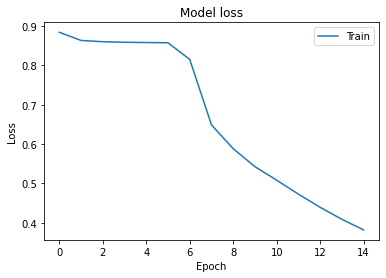

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

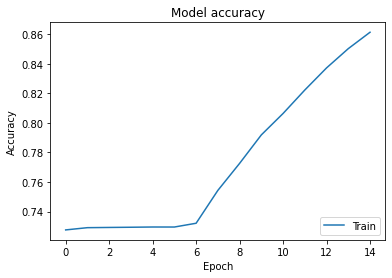

In [19]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()